In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Cell_BLAST as cb
cb.config.RANDOM_SEED = 0
cb.config.N_JOBS = 8

In [2]:
dataset = cb.data.ExprDataSet.read_dataset("../../Datasets/data/Baron_human/data.h5").normalize()

In [3]:
model = cb.directi.fit_DIRECTi(
    dataset, dataset.uns["seurat_genes"],
    latent_dim=10, cat_dim=20, epoch=200, patience=30,
    path="/tmp/cb/n_posterior_sample"
)

[DIRECTi epoch 0] train=2.451, val=2.426, time elapsed=1.7s Best save...
[DIRECTi epoch 1] train=2.412, val=2.356, time elapsed=0.7s Best save...
[DIRECTi epoch 2] train=1.585, val=0.864, time elapsed=0.7s Best save...
[DIRECTi epoch 3] train=0.778, val=0.818, time elapsed=0.7s Best save...
[DIRECTi epoch 4] train=0.746, val=0.814, time elapsed=0.7s Best save...
[DIRECTi epoch 5] train=0.742, val=0.754, time elapsed=0.7s Best save...
[DIRECTi epoch 6] train=0.738, val=0.741, time elapsed=0.7s Best save...
[DIRECTi epoch 7] train=0.734, val=0.738, time elapsed=0.7s Best save...
[DIRECTi epoch 8] train=0.731, val=0.731, time elapsed=0.6s Best save...
[DIRECTi epoch 9] train=0.725, val=0.733, time elapsed=0.7s
[DIRECTi epoch 10] train=0.714, val=0.709, time elapsed=0.7s Best save...
[DIRECTi epoch 11] train=0.701, val=0.703, time elapsed=0.7s Best save...
[DIRECTi epoch 12] train=0.693, val=0.694, time elapsed=0.7s Best save...
[DIRECTi epoch 13] train=0.687, val=0.685, time elapsed=0.7s 

[DIRECTi epoch 122] train=0.609, val=0.622, time elapsed=0.6s
[DIRECTi epoch 123] train=0.609, val=0.623, time elapsed=0.7s
[DIRECTi epoch 124] train=0.609, val=0.622, time elapsed=0.7s
[DIRECTi epoch 125] train=0.609, val=0.624, time elapsed=0.6s
[DIRECTi epoch 126] train=0.609, val=0.621, time elapsed=0.6s
[DIRECTi epoch 127] train=0.609, val=0.621, time elapsed=0.6s Best save...
[DIRECTi epoch 128] train=0.609, val=0.622, time elapsed=0.7s
[DIRECTi epoch 129] train=0.608, val=0.623, time elapsed=0.6s
[DIRECTi epoch 130] train=0.609, val=0.622, time elapsed=0.7s
[DIRECTi epoch 131] train=0.608, val=0.621, time elapsed=0.7s
[DIRECTi epoch 132] train=0.608, val=0.623, time elapsed=0.7s
[DIRECTi epoch 133] train=0.608, val=0.622, time elapsed=0.7s
[DIRECTi epoch 134] train=0.608, val=0.623, time elapsed=0.7s
[DIRECTi epoch 135] train=0.608, val=0.624, time elapsed=0.7s
[DIRECTi epoch 136] train=0.608, val=0.624, time elapsed=0.6s
[DIRECTi epoch 137] train=0.608, val=0.621, time elapsed=

In [4]:
ref_indices = np.random.choice(np.arange(dataset.shape[0]), 1000, replace=False)
query_indices = np.random.choice(
    np.setdiff1d(np.arange(dataset.shape[0]), ref_indices),
    200, replace=False
)

In [5]:
ref = dataset[ref_indices, :]
query = dataset[query_indices, :]

In [6]:
blast = cb.blast.BLAST([model], ref, n_posterior=0)
hits = blast.query(query, n_neighbors=50)
euclidean_distance = np.concatenate(hits.dist, axis=0)
posterior_distance_dict = {}
for n_posterior in (5, 10, 20, 50, 100, 500, 1000):
    print("==== n_posterior: %d ====" % n_posterior)
    blast = cb.blast.BLAST([model], ref, n_posterior=n_posterior)
    hits = blast.query(query, n_neighbors=50)
    posterior_distance_dict[n_posterior] = np.concatenate(hits.dist, axis=0)
    print()

[  Info   ] Projecting to latent space...
[  Info   ] Fitting nearest neighbor trees...
[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing Euclidean distances...
==== n_posterior: 5 ====
[  Info   ] Projecting to latent space...
[  Info   ] Fitting nearest neighbor trees...
[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...

==== n_posterior: 10 ====
[  Info   ] Projecting to latent space...
[  Info   ] Fitting nearest neighbor trees...
[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...

==== n_posterior: 20 ====
[  Info   ] Projecting to latent space...
[  Info   ] Fitting nearest neighbor trees...
[  Info   ] Projectin

In [7]:
n_posterior_list = [5, 10, 20, 50, 100, 500]
std_list = []
for n_posterior in n_posterior_list:
    std_list.append(np.std(
        (posterior_distance_dict[n_posterior] - posterior_distance_dict[1000]).ravel()
    ))
std_df = pd.DataFrame({
    "Number of posterior samples": n_posterior_list,
    "SD of posterior distance": std_list
})

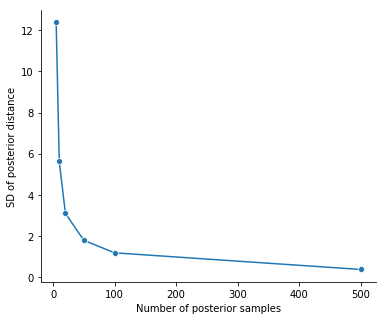

In [8]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.lineplot(
    x="Number of posterior samples", y="SD of posterior distance",
    style=1, markers=True, dashes=False, data=std_df, ax=ax, legend=False
)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.savefig("./pd_std.pdf", bbox_inches="tight")